In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tfi_exact # for later comparison

In [6]:
# a)
import a_mps
L = 14
psi0 = a_mps.init_spinup_MPS(14)
Sz = np.array([[1., 0.], [0., -1.]])
exp_val_Sz = psi0.site_expectation_value(Sz)
print(exp_val_Sz)
Sx = np.array([[0., 1.], [1., 0.]])
exp_val_Sx = psi0.site_expectation_value(Sx)
print(exp_val_Sx)
assert exp_val_Sz[0] == 1.
assert exp_val_Sx[0] == 0.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# b)
def init_spinright_MPS(L):
    """Return a product state with all spins up as an MPS"""
    B = np.zeros([1, 2, 1], np.float)
    B[0, 0, 0] = B[0, 1, 0] = 0.5**0.5
    S = np.ones([1], np.float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return a_mps.MPS(Bs, Ss)


psi1 = init_spinright_MPS(14)
exp_val_Sz = psi1.site_expectation_value(Sz)
print(exp_val_Sz)
exp_val_Sx = psi1.site_expectation_value(Sx)
print(exp_val_Sx)
assert exp_val_Sz[0] == 0.
assert abs(exp_val_Sx[0] -1.) < 1.e-15  # correct up to rounding errors of machine precision


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/tmp/ipykernel_9348/2197125737.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = np.zeros([1, 2, 1], np.float)
/tmp/ipykernel_9348/2197125737.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = np.ones([1], np.float)


In [8]:
# c)
import b_model
for g in [0.5, 1., 1.5]:
    print("g =", g)
    model = b_model.TFIModel(L, 1. , g)
    print("energy of |up.... up>", model.energy(psi0))
    print("energy of |right ... right>", model.energy(psi1))
# as expected :D

g = 0.5
energy of |up.... up> -7.0
energy of |right ... right> -13.000000000000004
g = 1.0
energy of |up.... up> -14.0
energy of |right ... right> -13.000000000000004
g = 1.5
energy of |up.... up> -21.0
energy of |right ... right> -13.000000000000004


For the Sz up state only the g term of the Hamiltonian contributes.
While for the Sx right state only the J term of the Hamiltonian contributes.

In [9]:
# d) Imaginairy time evolution
import c_tebd
E, psi, model = c_tebd.example_TEBD_gs_finite(14, 1., 1.5)

finite TEBD, (imaginary time evolution)
L=14, J=1.0, g=1.50
dt = 0.10000: E = -23.1210722544100
dt = 0.01000: E = -23.2133644786914
dt = 0.00100: E = -23.2220037685472
dt = 0.00010: E = -23.2228606166766
dt = 0.00001: E = -23.2229463553360
final bond dimensions:  [2, 4, 8, 13, 17, 18, 18, 18, 17, 13, 8, 4, 2]
Exact diagonalization: E = -23.2229594341173
relative error:  5.631832278549061e-07


In case of imaginairy time evolution the Ubonds are not unitairy. Therefore the canonical form of the MPS will be destroyed. However the destruction is not so bad if the time steps are chosen small enough. Therefore we lower the time steps successively for a better convergence. 

# Global quench

Text(0.5, 0, 'time $t$')

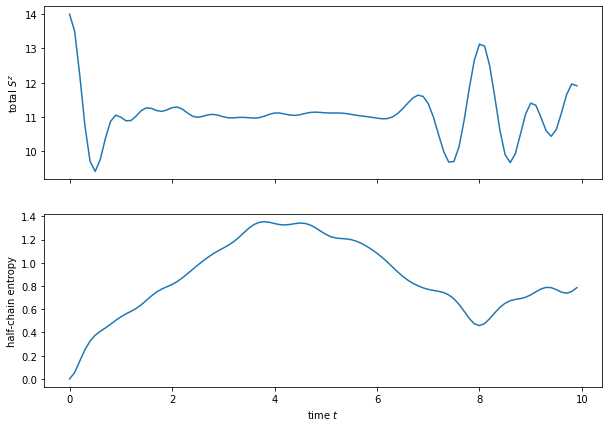

In [10]:
# e) 
chi_max = 30
eps = 1.e-10
L = 14
model = b_model.TFIModel(L, 1., 1.5)
dt = 0.1
N_steps = 1
U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt) # <-- Include imaginairy unit !
ts = np.arange(0., 10., dt*N_steps)
psi = a_mps.init_spinup_MPS(L)
Sz_tot = []
S = []
for t in ts:
    Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
    S.append(psi.entanglement_entropy()[psi.L//2])
    c_tebd.run_TEBD(psi, U_bonds, N_steps, chi_max, eps)
    
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
ax1.plot(ts, Sz_tot)
ax2.plot(ts, S)
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")

L= 14
dt=0.100, chi=30
dt=0.010, chi=30
dt=0.020, chi=128


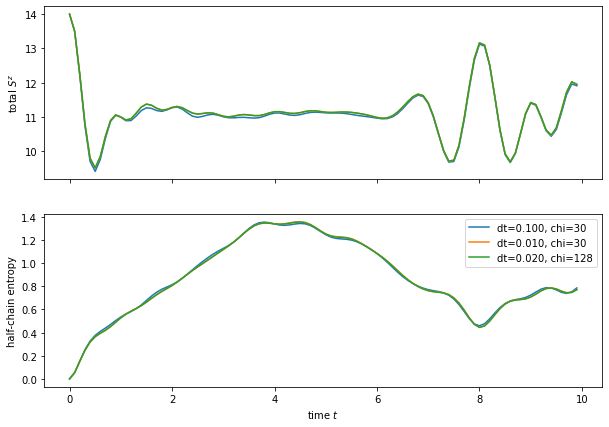

In [11]:
# f) converged in dt, chi?
L = 14
print("L=",L)
model = b_model.TFIModel(L, 1., 1.5)
eps = 1.e-10

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
for dt, N_steps, chi in [(0.1, 1, 30), (0.01, 10, 30), (0.02, 5, 128)]:  
    lbl = "dt={dt:.3f}, chi={chi:d}".format(dt=dt, chi=chi)
    print(lbl)
    U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
    ts = np.arange(0., 10., dt*N_steps)
    psi = a_mps.init_spinup_MPS(L)
    Sz_tot = []
    S = []
    for t in ts:
        Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
        S.append(psi.entanglement_entropy()[psi.L//2])
        c_tebd.run_TEBD(psi, U_bonds, N_steps, chi_max, eps)
    ax1.plot(ts, Sz_tot, label=lbl)
    ax2.plot(ts, S, label=lbl)

ax2.legend()
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()

L= 50
dt=0.100, chi=30
dt=0.020, chi=30
dt=0.020, chi=60
dt=0.020, chi=120
dt=0.010, chi=60


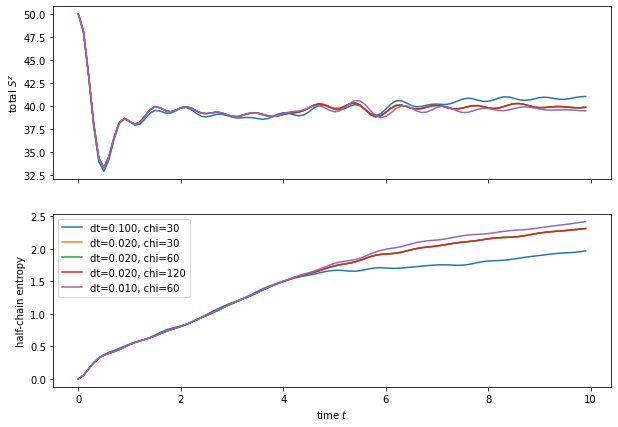

In [12]:
# and again for larger L

L = 50
print("L=",L)
model = b_model.TFIModel(L, 1., 1.5)
eps = 1.e-10

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
for dt, N_steps, chi in [(0.1, 1, 30), (0.02, 5, 30), (0.02, 5, 60), (0.02, 5, 120), (0.01, 10, 60)]:
    lbl = "dt={dt:.3f}, chi={chi:d}".format(dt=dt, chi=chi)
    print(lbl)
    U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
    ts = np.arange(0., 10., dt*N_steps)
    psi = a_mps.init_spinup_MPS(L)
    Sz_tot = []
    S = []
    for t in ts:
        Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
        S.append(psi.entanglement_entropy()[psi.L//2])
        c_tebd.run_TEBD(psi, U_bonds, N_steps, chi_max, eps)
    ax1.plot(ts, Sz_tot, label=lbl)
    ax2.plot(ts, S, label=lbl)

ax2.legend(loc='upper left')
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()

In [ ]:
def run_TEBD(psi, U_bonds, N_steps, chi_max, eps):
    """Evolve the state `psi` for `N_steps` time steps with (first order) TEBD.

    The state psi is modified in place."""
    Nbonds = psi.L - 1
    assert len(U_bonds) == Nbonds
    for n in range(N_steps):
        for k in [0, 1]:  # even, odd
            for i_bond in range(k, Nbonds, 2):
                update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    # done

In [13]:
# g)
def run_TEBD_secondorder(psi, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps):
    Nbonds = psi.L - 1
    assert len(U_bonds) == len(U_bonds_half_dt) == Nbonds
    for i_bond in range(0, Nbonds, 2): # even bonds
        c_tebd.update_bond(psi, i_bond, U_bonds_half_dt[i_bond], chi_max, eps)
    for i_bond in range(1, Nbonds, 2): # odd bonds
        c_tebd.update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    for n in range(N_steps- 1):
        for k in [0, 1]:  # even and odd
            for i_bond in range(k, Nbonds, 2):
                c_tebd.update_bond(psi, i_bond, U_bonds[i_bond], chi_max, eps)
    for i_bond in range(0, Nbonds, 2): # even bonds
        c_tebd.update_bond(psi, i_bond, U_bonds_half_dt[i_bond], chi_max, eps)
    # done

L= 50
dt=0.100, chi=30
dt=0.020, chi=30
dt=0.020, chi=60
dt=0.020, chi=120
dt=0.010, chi=60


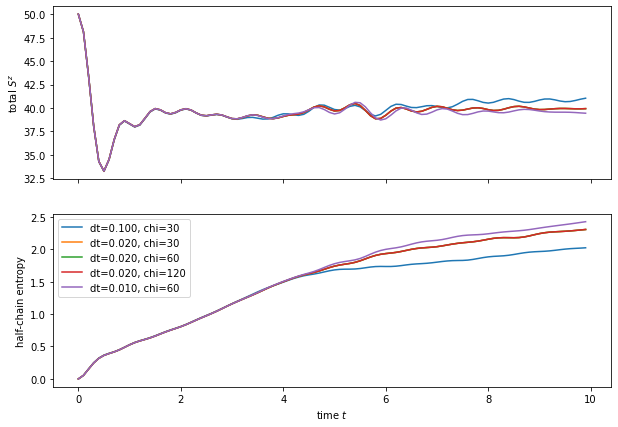

In [14]:
# regenerate previous plot: almost same code, changes marked with comments.
L = 50
print("L=",L)
model = b_model.TFIModel(L, 1., 1.5)
eps = 1.e-10

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
for dt, N_steps, chi in [(0.1, 1, 30), (0.02, 5, 30), (0.02, 5, 60), (0.02, 5, 120), (0.01, 10, 60)]:  
    lbl = "dt={dt:.3f}, chi={chi:d}".format(dt=dt, chi=chi)
    print(lbl)
    U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
    U_bonds_half_dt = c_tebd.calc_U_bonds(model, 1.j*dt/2.)  # this line is new
    ts = np.arange(0., 10., dt*N_steps)
    psi = a_mps.init_spinup_MPS(L)
    Sz_tot = []
    S = []
    for t in ts:
        Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
        S.append(psi.entanglement_entropy()[psi.L//2])
        run_TEBD_secondorder(psi, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps)  # this line changed
    ax1.plot(ts, Sz_tot, label=lbl)
    ax2.plot(ts, S, label=lbl)

ax2.legend(loc='upper left')
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()


L= 50
dt=0.100, chi=30
dt=0.010, chi=30


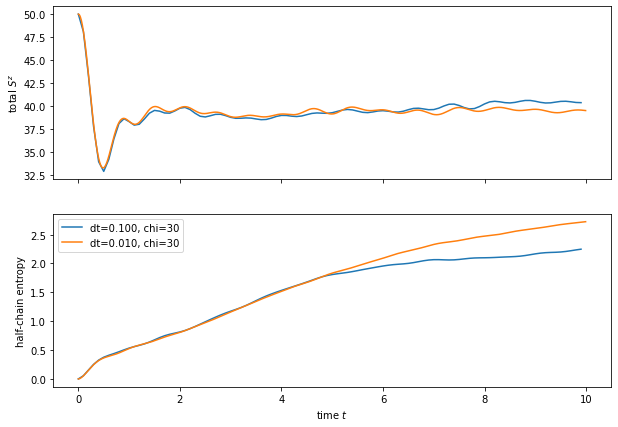

dt=0.100, chi=30
dt=0.010, chi=30


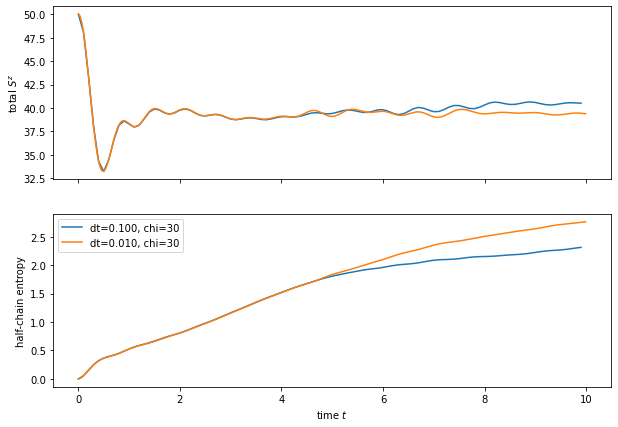

In [28]:
# regenerate previous plot: almost same code, changes marked with comments.
L = 50
print("L=",L)
model = b_model.TFIModel(L, 1., 1.5)
eps = 1.e-10

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
for dt, N_steps, chi in [(0.1, 1, 30), (0.01, 1, 30)]:
    lbl = "dt={dt:.3f}, chi={chi:d}".format(dt=dt, chi=chi)
    print(lbl)
    U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
    ts = np.arange(0., 10., dt*N_steps)
    psi = a_mps.init_spinup_MPS(L)
    Sz_tot = []
    S = []
    for t in ts:
        Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
        S.append(psi.entanglement_entropy()[psi.L//2])
        c_tebd.run_TEBD(psi, U_bonds, N_steps, chi_max, eps)
    ax1.plot(ts, Sz_tot, label=lbl)
    ax2.plot(ts, S, label=lbl)
    
ax2.legend(loc='upper left')
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
for dt, N_steps, chi in [(0.1, 1, 30), (0.01, 1, 30)]:  
    lbl = "dt={dt:.3f}, chi={chi:d}".format(dt=dt, chi=chi)
    print(lbl)
    U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
    U_bonds_half_dt = c_tebd.calc_U_bonds(model, 1.j*dt/2.)  # this line is new
    ts = np.arange(0., 10., dt*N_steps)
    psi = a_mps.init_spinup_MPS(L)
    Sz_tot = []
    S = []
    for t in ts:
        Sz_tot.append(np.sum(psi.site_expectation_value(model.sigmaz)))
        S.append(psi.entanglement_entropy()[psi.L//2])
        run_TEBD_secondorder(psi, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps)  # this line changed
    ax1.plot(ts, Sz_tot, label=lbl)
    ax2.plot(ts, S, label=lbl)

ax2.legend(loc='upper left')
ax1.set_ylabel("total $S^z$")
ax2.set_ylabel("half-chain entropy")
ax2.set_xlabel("time $t$")
plt.show()


# Local quench 
i.e. an eigenstate that is locally perturbed and then the perturbation is evolved in time

In [15]:
E, psi0, model = c_tebd.example_TEBD_gs_finite(50, 1., 1.5)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=1.50
dt = 0.10000: E = -82.9616282068189
dt = 0.01000: E = -83.3684682230389
dt = 0.00100: E = -83.4079241722206
dt = 0.00010: E = -83.4118520933584
dt = 0.00001: E = -83.4122451665898
final bond dimensions:  [2, 4, 8, 13, 17, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 17, 13, 8, 4, 2]


dt 0.01


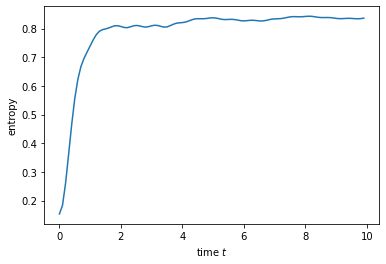

In [16]:
# get a copy of the ground state, to which we apply sigma_x on site i0 = L//2
psi = psi0.copy()
i0 = psi.L//2
new_B = np.tensordot(model.sigmax, psi.Bs[i0], axes=(1, 1))  # i [i*], vL [i] vR
new_B = np.transpose(new_B, [1, 0, 2]) # l p r
psi.Bs[i0] = new_B

dt = 0.01
chi_max = 50
eps = 1.e-10

# do a time evolution
U_bonds = c_tebd.calc_U_bonds(model, 1.j*dt)
print("dt",dt)
U_bonds_half_dt = c_tebd.calc_U_bonds(model, 1.j*dt/2.)  # this line is new
ts = np.arange(0., 10., dt*N_steps)
S = []
for t in ts:
    S.append(psi.entanglement_entropy())
    run_TEBD_secondorder(psi, U_bonds, U_bonds_half_dt, N_steps, chi_max, eps)  # this line changed
S = np.array(S)
# just for comparision: plot the half-chain entanglement
plt.figure()
plt.plot(ts, S[:, i0])
plt.xlabel("time $t$")
plt.ylabel("entropy")
plt.show()

In [17]:
# Some code to generate a nice colorplot
def colorplot(xs, ys, data, **kwargs):
    """Create a colorplot with matplotlib.pyplot.imshow.

    Parameters
    ----------
    xs : 1D array, shape (n,)
        x-values of the points for which we have data; evenly spaced
    ys : 1D array, shape (m,)
        y-values of the points for which we have data; evenly spaced
    data : 2D array, shape (m, n)
        ``data[i, j]`` corresponds to the points ``(xs[i], ys[j])``
    **kwargs :
        additional keyword arguments, given to `imshow`.
    """
    data = np.asarray(data)
    if data.shape != (len(xs), len(ys)):
        raise ValueError("Shape of data doesn't match len of xs and ys!")
    dx = (xs[-1] - xs[0])/(len(xs)-1)
    assert abs(dx - (xs[1]-xs[0])) < 1.e-10
    dy = (ys[-1] - ys[0])/(len(ys)-1)
    assert abs(dy - (ys[1]-ys[0])) < 1.e-10
    extent = (xs[0] - 0.5 * dx, xs[-1] + 0.5 * dx,  # left, right
              ys[0] - 0.5 * dy, ys[-1] + 0.5 * dy)  # bottom, top
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('interpolation', 'nearest')
    kwargs.setdefault('extent', extent)
    # convention of imshow: matrix like data[row, col] with (0, 0) top left.
    # but we want data[col, row] with (0, 0) bottom left -> transpose and invert y axis
    plt.imshow(data.T[::-1, :], **kwargs)

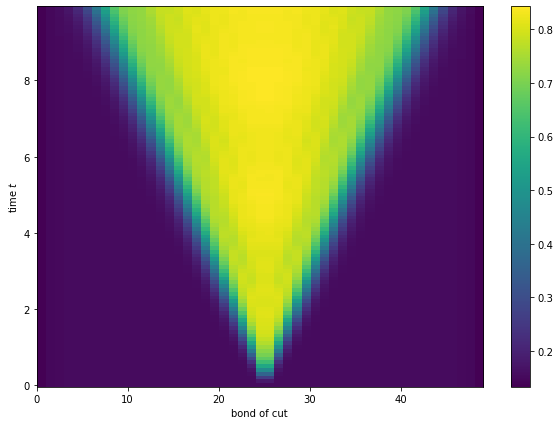

In [18]:
plt.figure(figsize=(10, 7))
xs = np.arange(0.5, psi.L-1, 1)
colorplot(xs, ts, S.T)
plt.xlabel("bond of cut")
plt.ylabel("time $t$")
plt.colorbar()
plt.show()